In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#####  Создаем DF

In [4]:
columns=['id',
 'region',
 'objElemLivingCnt',
 'objElemParkingCnt',
 'objSquareLiving',
 'objLkClassDesc',
 'residentialBuildings',
 'objFloorCnt',
 'objFlatCnt',
 'objFlatSq',
 'objPriceAvg',
 'objReady100PercDt']

In [5]:
df=pd.read_pickle('build.pkl')[columns].drop_duplicates('id')
df['year']=pd.to_datetime(df['objReady100PercDt']).dt.year.astype('str')
df['kv_metr']=df['objSquareLiving']/df['objFlatCnt']
live_class = df[df['objLkClassDesc'] != 'Другое']['objLkClassDesc'].unique() 
region = df['region'].unique()

In [6]:
for cla in live_class:
    for reg in region:
        filter = (df['objLkClassDesc'] == cla) & (df['region'] == reg)
        df.loc[filter,'med_price'] = df.loc[filter,'objPriceAvg'].fillna(df.loc[filter,'objPriceAvg'].median())
        df.loc[filter,'avg_price'] = df.loc[filter,'objPriceAvg'].fillna(df.loc[filter,'objPriceAvg'].mean())
        
        
order = ['Другое', 'Типовой', 'Комфорт', 'Бизнес', 'Элитный']
df['code_type_obj'] = df['objLkClassDesc'].astype('category').cat.set_categories(order).cat.codes
        

df.loc[df['med_price'].isnull(),'med_price'] = df.med_price.median()
df.loc[df['avg_price'].isnull(),'avg_price'] = df.avg_price.median()

df['med_price'] = df['med_price'].astype(int)
df['avg_price'] = df['avg_price'].astype(int)


Определяем выборку регионов

<Axes: xlabel='region'>

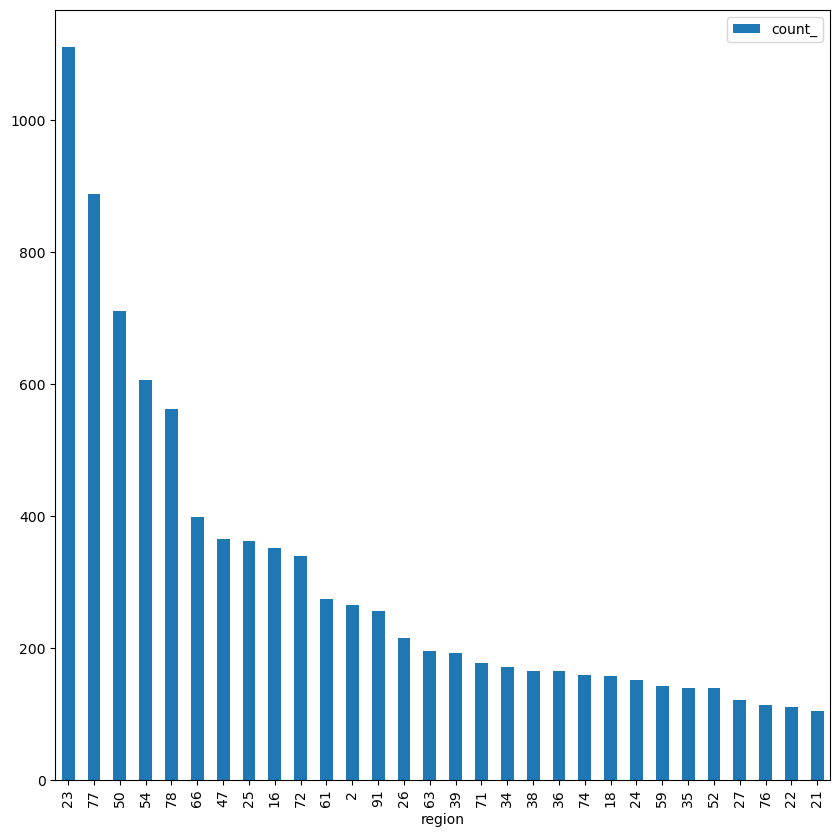

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 9,12
df_grouped=df.groupby(['region'])['id'].count().reset_index().set_index(['region'])
df_grouped = df_grouped.rename(columns={'id': 'count_'})
df_grouped[df_grouped.count_ > 100].sort_values('count_',ascending = False).plot(kind='bar',stacked=True,figsize=(10,10))

Возьмем первые топ 5 регионов

In [9]:
top_reg=df.groupby(['region']).count().sort_values('id',ascending=False).reset_index().head(5)['region']

In [10]:
top_reg=df.groupby(['region']).count().sort_values('id',ascending=False).reset_index().head(5)['region']
df=df[df['region'].isin(top_reg)].reset_index(drop=True)
df.head()

,id,region,objElemLivingCnt,objElemParkingCnt,objSquareLiving,objLkClassDesc,residentialBuildings,objFloorCnt,objFlatCnt,objFlatSq,objPriceAvg,objReady100PercDt,year,kv_metr,med_price,avg_price,code_type_obj
0,56006,54,24,0,1003.20,Комфорт,1,4,24,1003.2,NaN,2024-12-31,2024,41.800000,116964,123119,2
1,18709,50,272,30,12093.84,Комфорт,1,18,272,12093.84,95270.0,2023-12-31,2023,44.462647,95270,95270,2
2,18708,50,272,0,12057.80,Комфорт,1,17,272,12057.8,100727.0,2023-12-31,2023,44.330147,100727,100727,2
3,27803,54,12,0,889.20,Типовой,1,3,12,889.2,NaN,2024-03-31,2024,74.100000,77721,77696,1
4,23862,54,6,0,787.20,Типовой,1,3,6,787.2,NaN,2024-03-31,2024,131.200000,77721,77696,1


график этажей,парковок,колв-во квартир

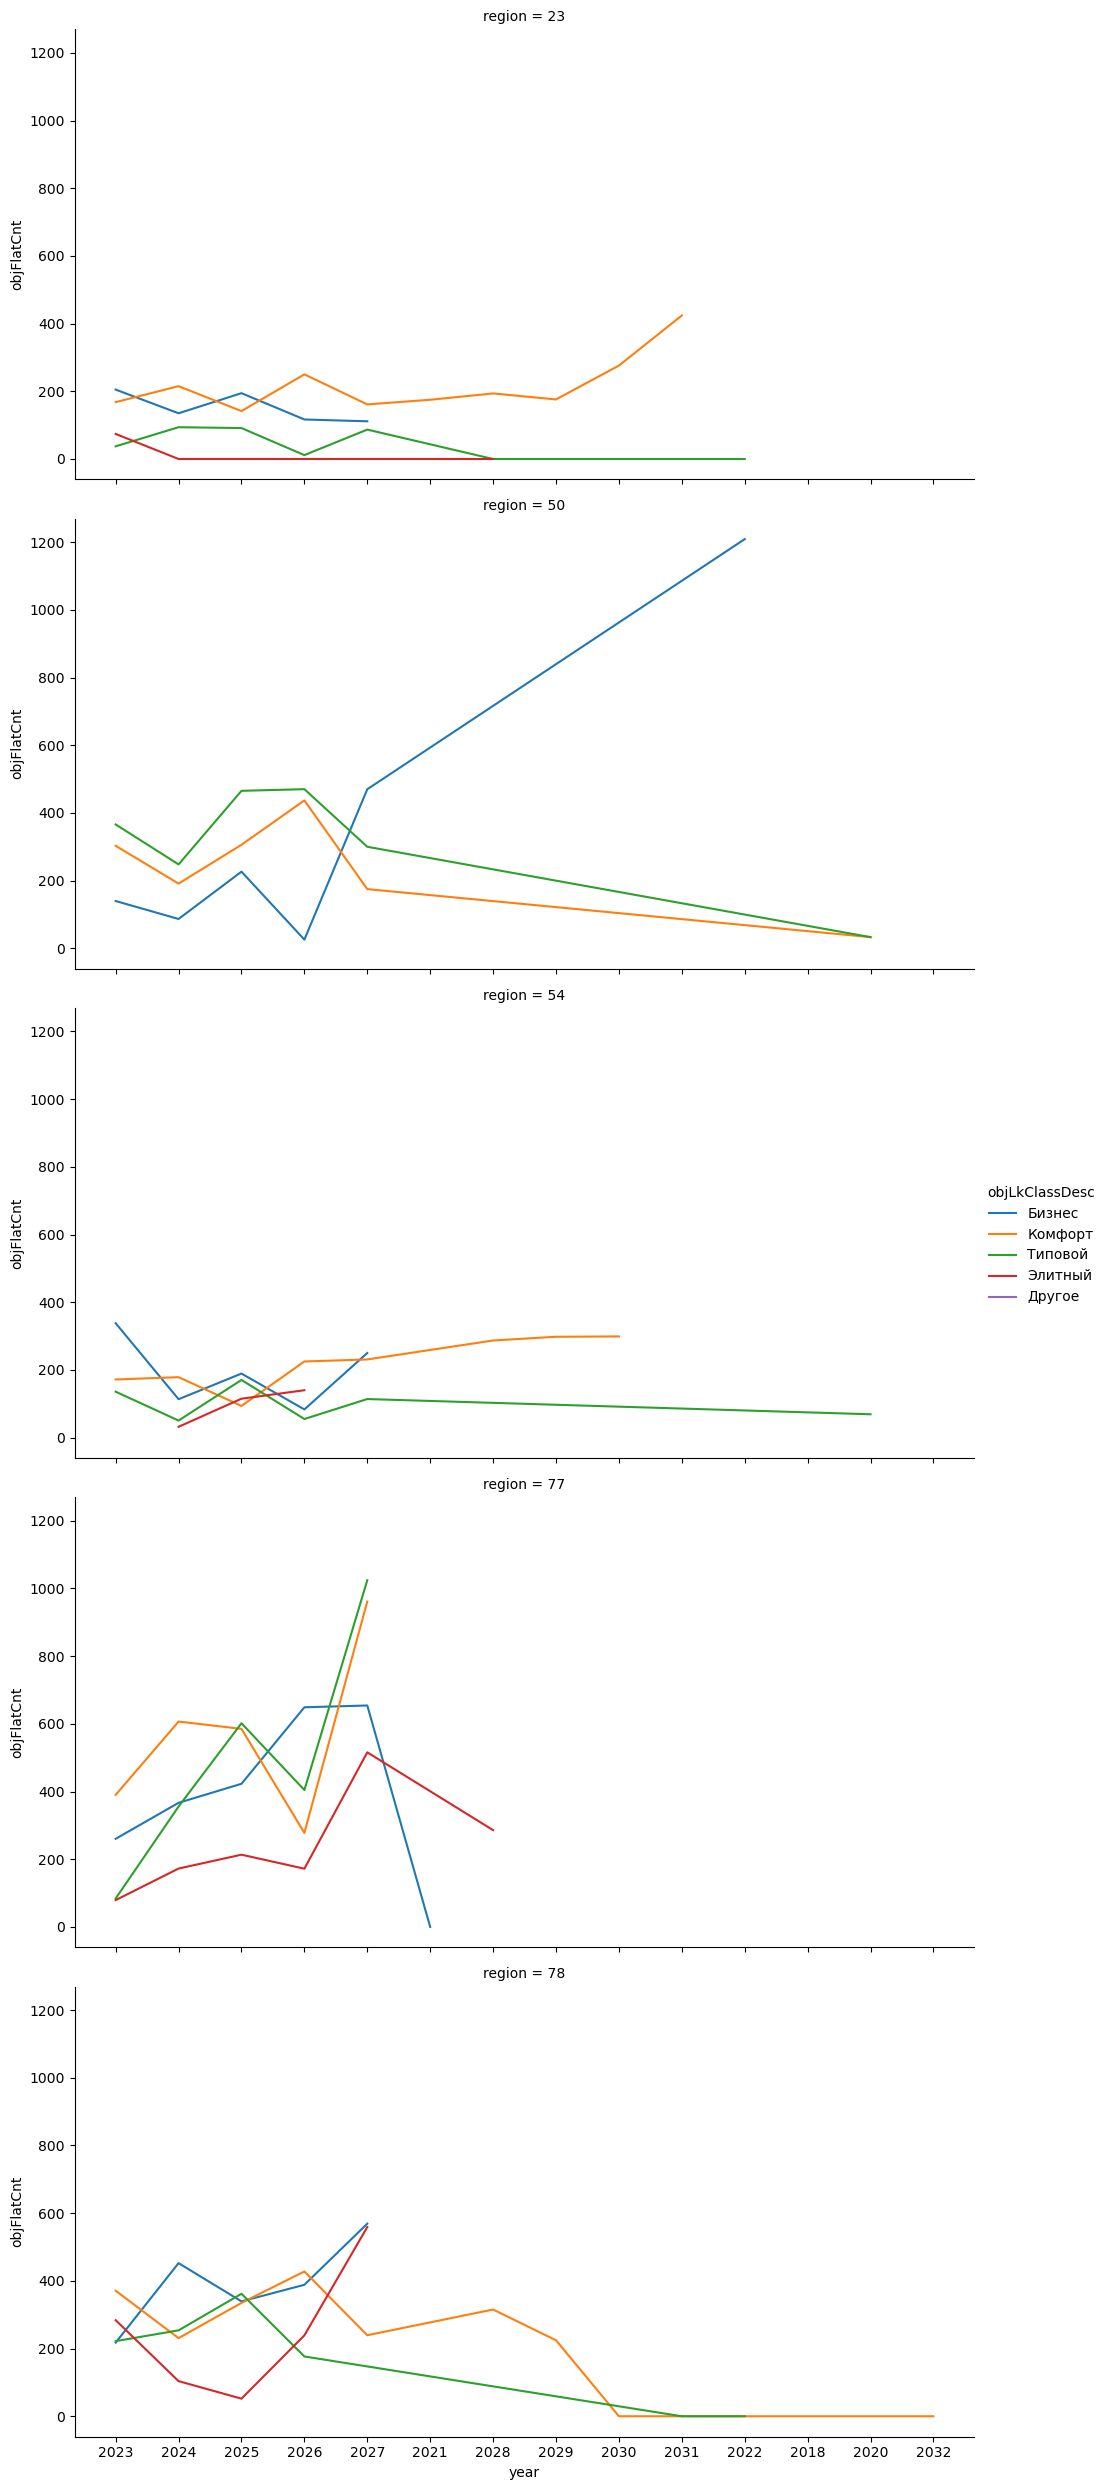

In [11]:
target=['objElemParkingCnt','objFloorCnt','objFlatCnt']

sns.relplot(
    x='year',
    y='objFlatCnt',
    hue='objLkClassDesc',
    data=df.groupby(['region','objLkClassDesc','year'])['objFlatCnt'].mean().reset_index(),
    row='region',
    kind='line',
    aspect=2,
    height=5)

В основном, кол-во квартир на объект из года в год будет увеличиваться.

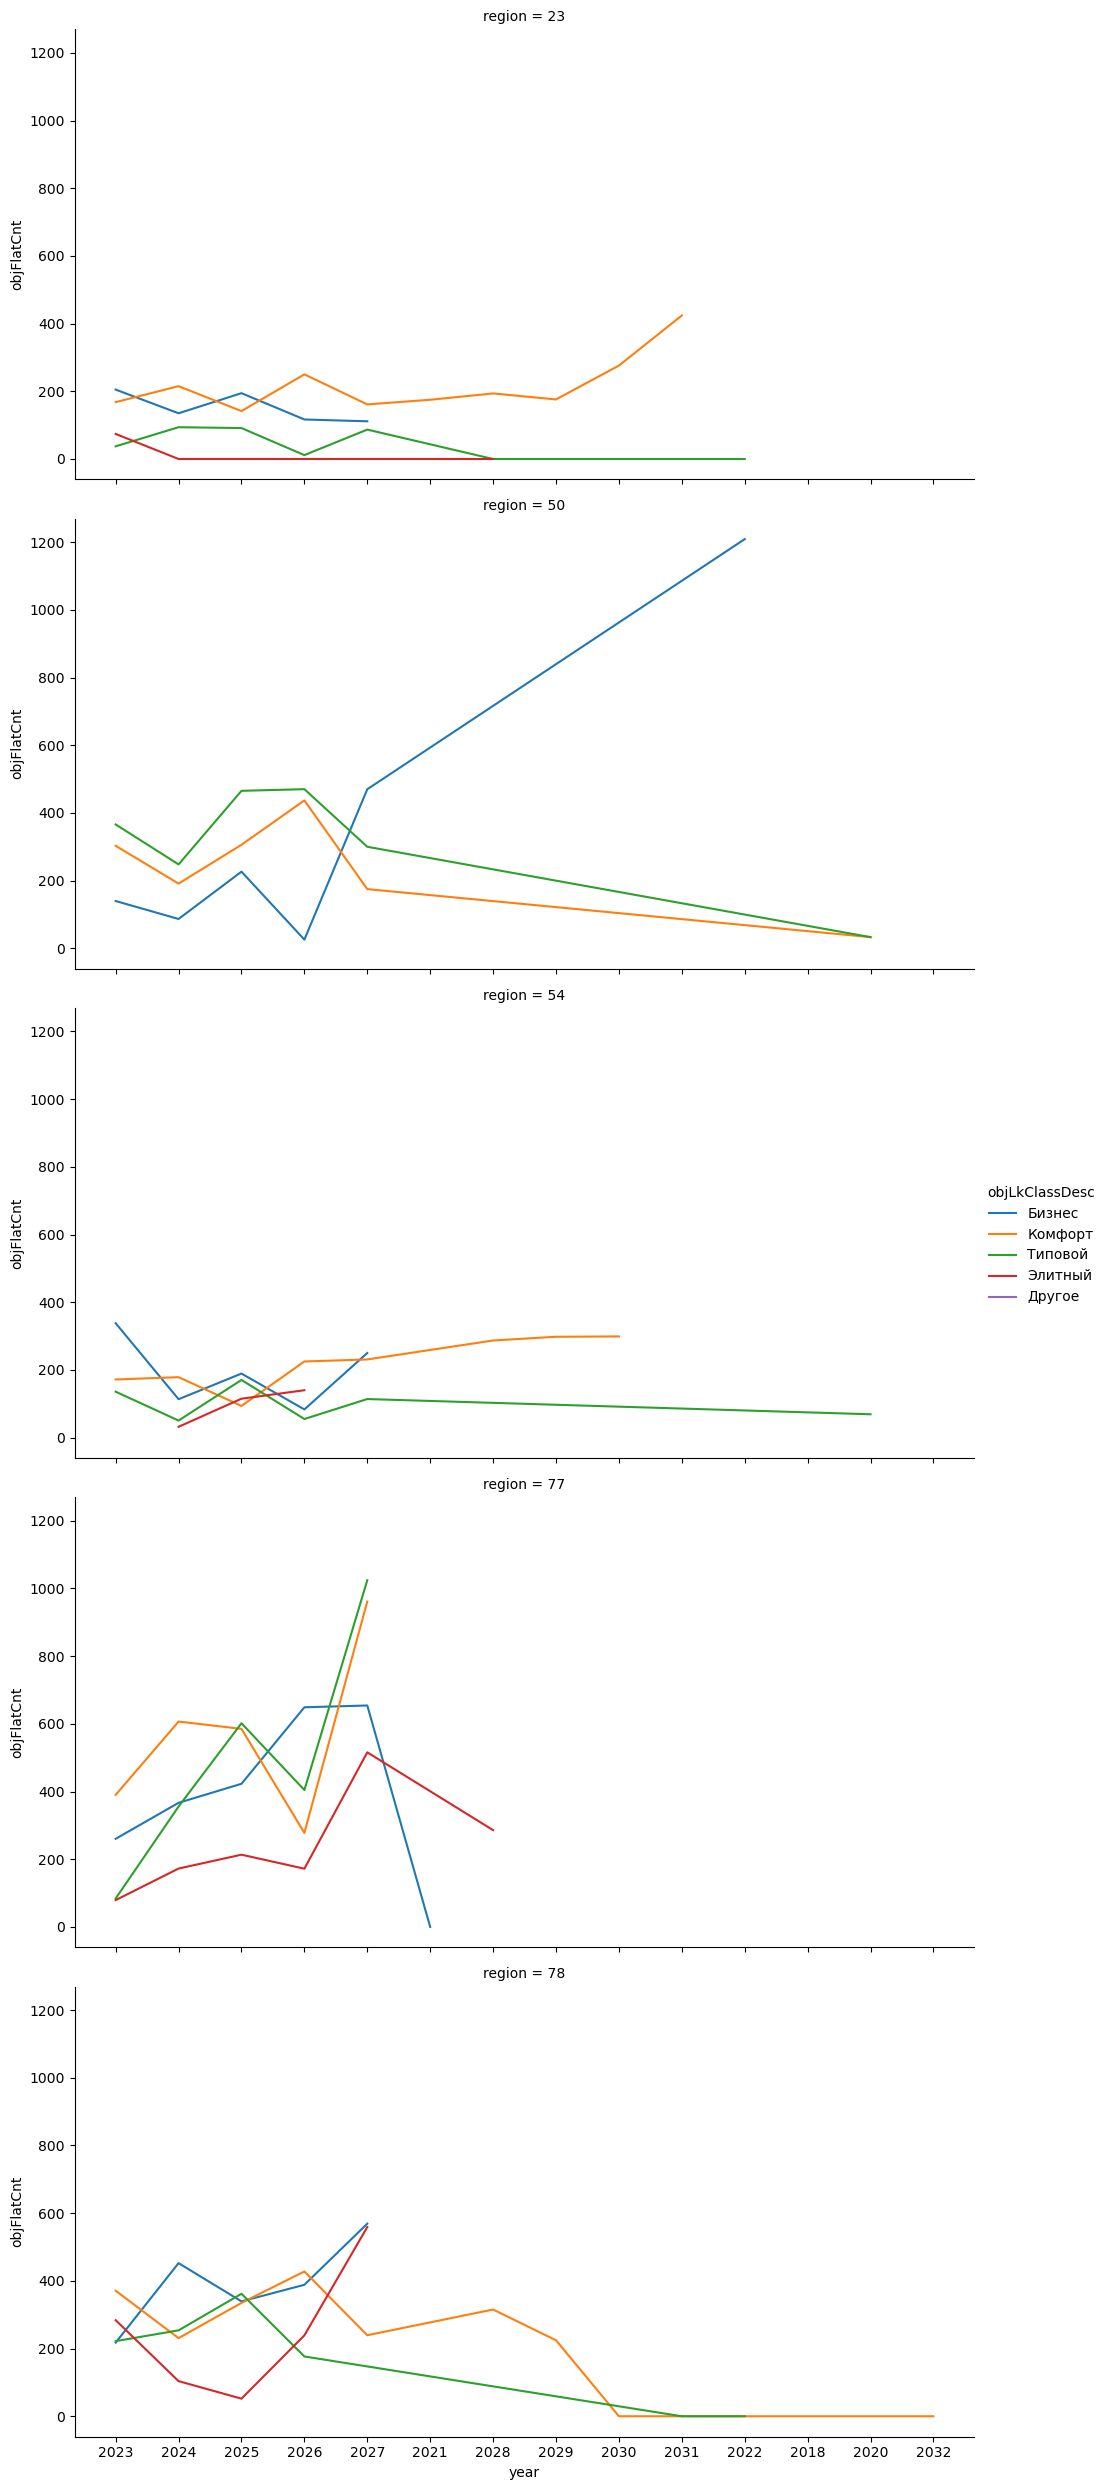

In [12]:
sns.relplot(
    x='year',
    y='objFlatCnt',
    hue='objLkClassDesc',
    data=df.groupby(['region','objLkClassDesc','year'])['objFlatCnt'].mean().reset_index(),
    row='region',
    kind='line',
    aspect=2,
    height=5)

в 23 регионе элитные дома строят на уровне первого этажа

в 50 растет кол-во квартир на объект бизнес сегмента, тогда как обычные дома идут на спад. Элитных домов не наблюдается

в 77 регионе тенденция на меньшее кол-во квартир на объекте сегмента бизнес\элитный, когда дома класса комфорт\типовые имеют обратный показатель

Паркинг

In [13]:
df_parking = df[['region','objLkClassDesc','year','objElemParkingCnt','objFlatCnt']]
df_parking_long = pd.melt(df_parking,var_name='type',value_name='values',
                        id_vars=['region','objLkClassDesc','year'])
df_parking_long.head()

,region,objLkClassDesc,year,type,values
0,54,Комфорт,2024,objElemParkingCnt,0
1,50,Комфорт,2023,objElemParkingCnt,30
2,50,Комфорт,2023,objElemParkingCnt,0
3,54,Типовой,2024,objElemParkingCnt,0
4,54,Типовой,2024,objElemParkingCnt,0


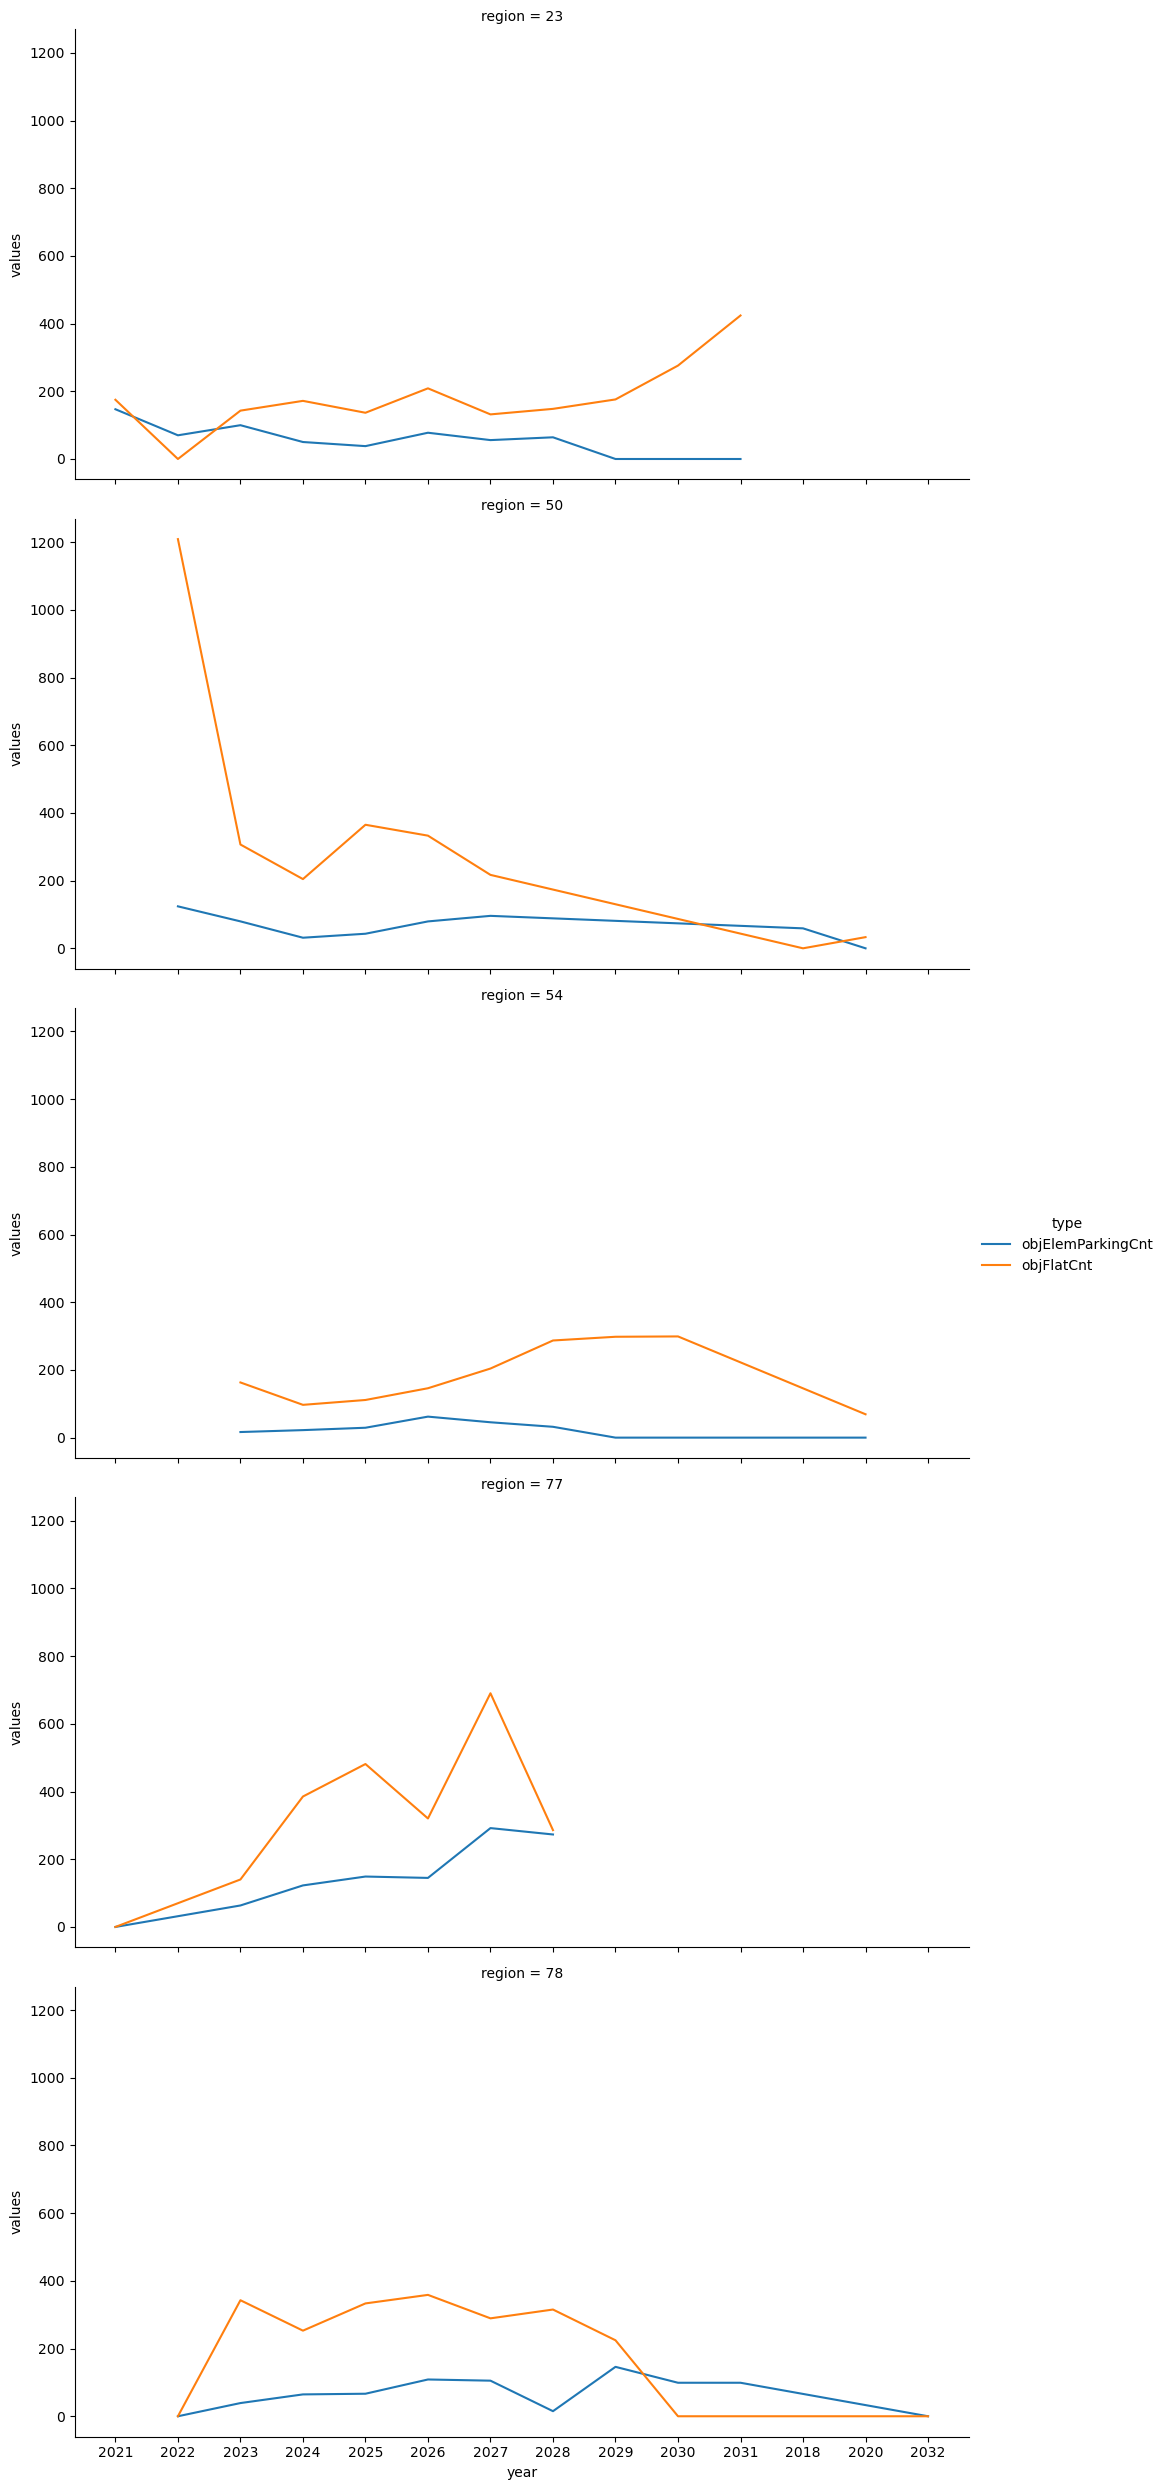

In [14]:
grouped_df=df_parking_long.groupby(['region',
                                  'year','type'])['values'].mean().reset_index()

sns.relplot(
    x='year',
    y='values',
    data=grouped_df,
    row='region',
    hue='type',
    kind='line',
    aspect=2,
    height=5)



до 2030 года количество парковочных мест растет\убывает в соответсивии изменения колличества квартир на объектах

разбивка по классу жилья

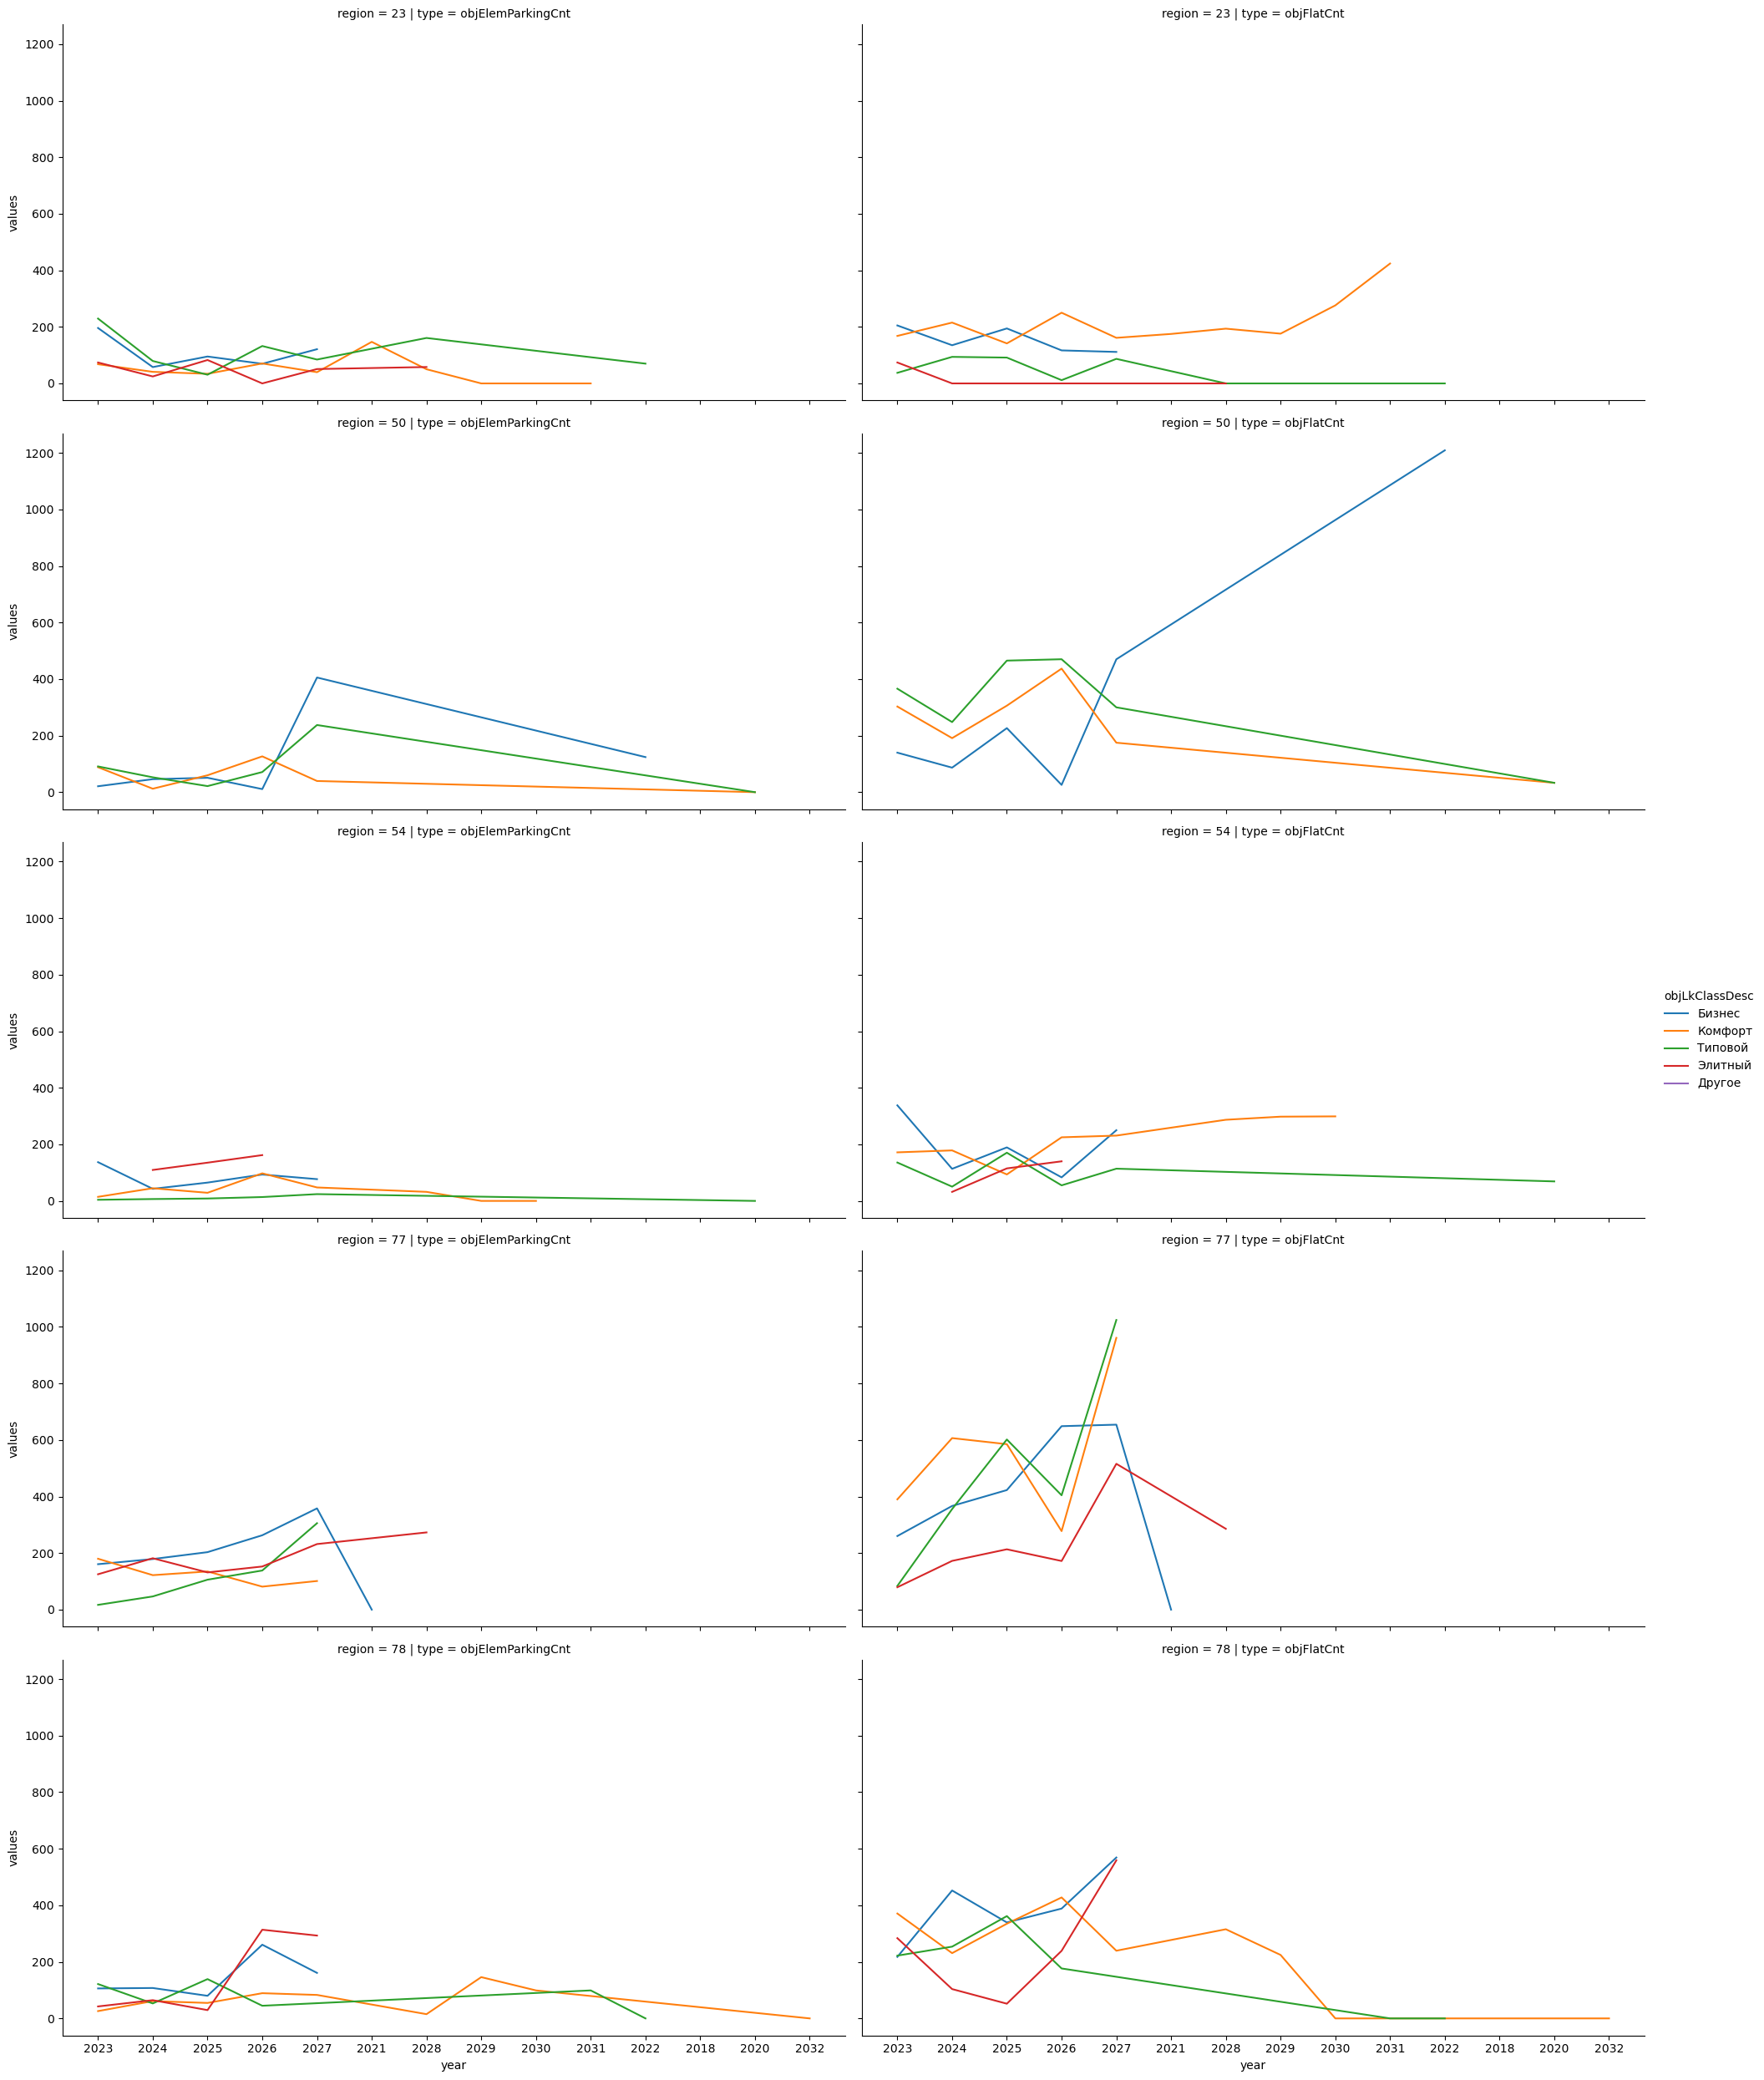

In [15]:
sns.relplot(
    x='year',
    y='values',
    hue='objLkClassDesc',
    data=df_parking_long.groupby(['region',
                                  'objLkClassDesc',
                                  'year','type'])['values'].mean().reset_index(),
    row='region',
    col='type',
    kind='line',
    aspect=2,
    height=5)

<Axes: xlabel='year', ylabel='values'>

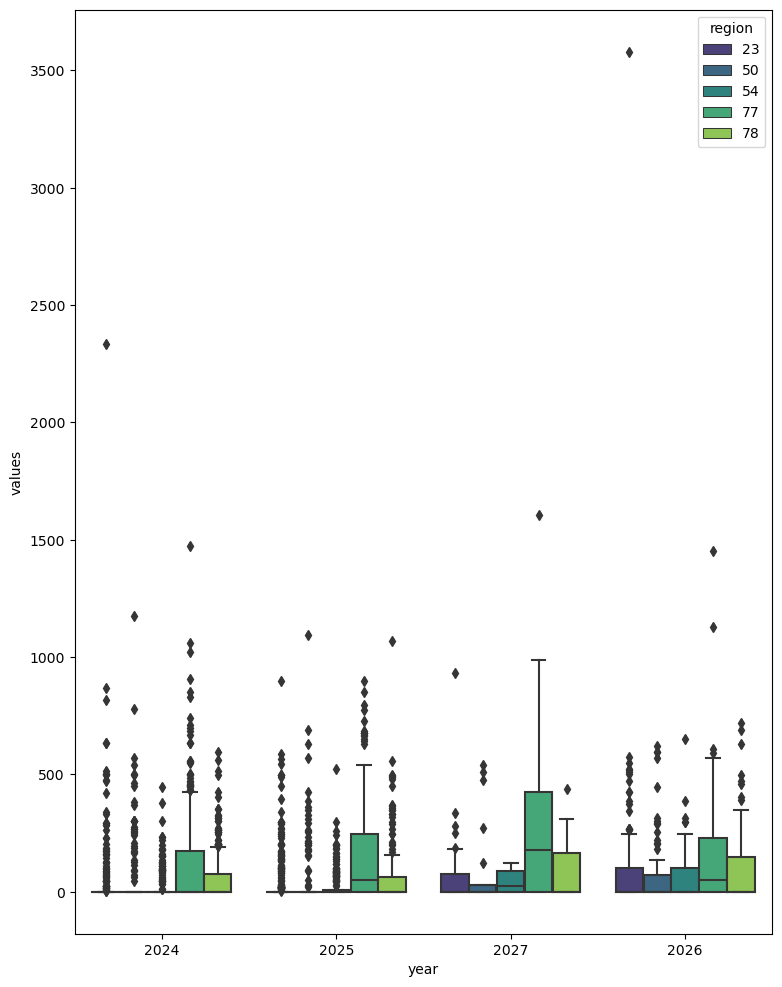

In [16]:
sns.boxplot(
    x='year',
    y='values',
    hue='region',
    data=df_parking_long.query('type == "objElemParkingCnt" and year in("2024","2025","2026","2027")'),
    palette='viridis')

можно откинуть значения до 1100 для более читабельного графика

<Axes: xlabel='year', ylabel='values'>

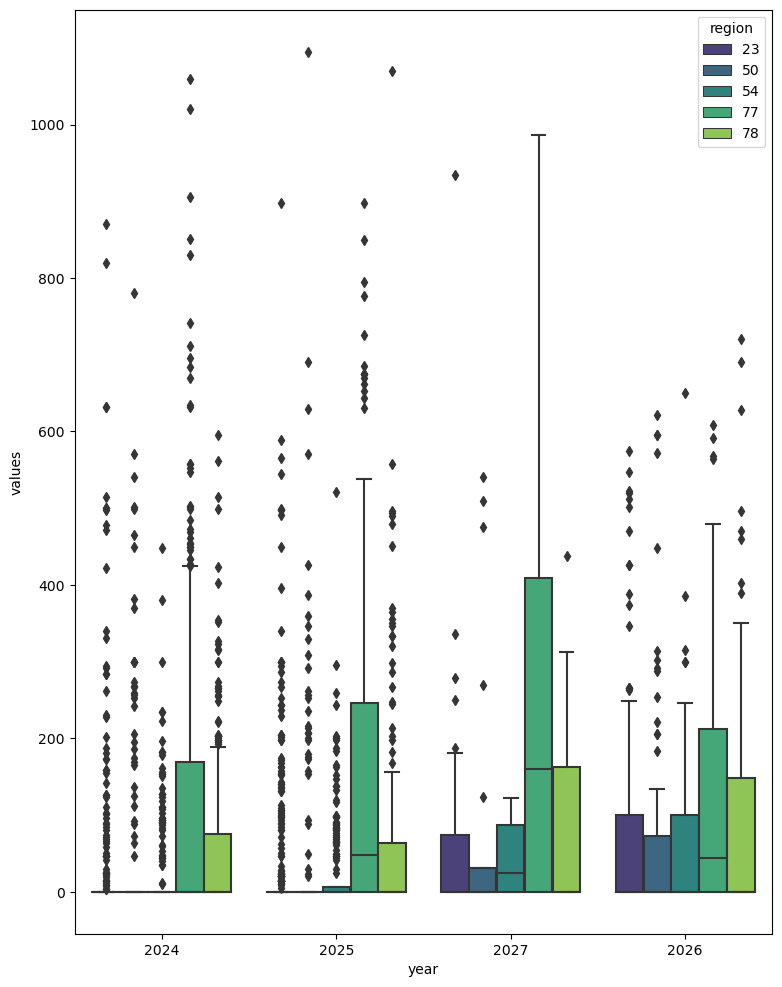

In [17]:
sns.boxplot(
    x='year',
    y='values',
    hue='region',
    data=df_parking_long.query('type == "objElemParkingCnt" and year in("2024","2025","2026","2027") and values < 1100'),
    palette='viridis')

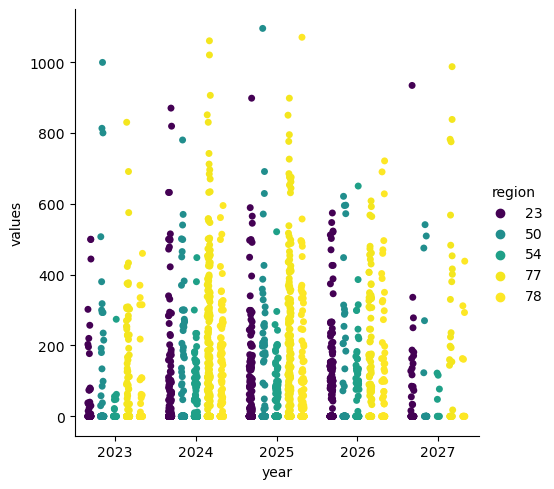

In [19]:
year_check=["2023","2024","2025","2026","2027"]
sns.catplot(
    x='year',
    y='values',
    order=year_check,
    hue='region',
    data=df_parking_long.query('type == "objElemParkingCnt" and values < 1100'),
    dodge=True,
    palette='viridis')

График цен

In [20]:
df_prices = df[['region','objLkClassDesc','year','med_price','avg_price']]
df_price_long = pd.melt(df_prices,var_name='type',value_name='price',
                        id_vars=['region','objLkClassDesc','year'])
df_price_long.head()

,region,objLkClassDesc,year,type,price
0,54,Комфорт,2024,med_price,116964
1,50,Комфорт,2023,med_price,95270
2,50,Комфорт,2023,med_price,100727
3,54,Типовой,2024,med_price,77721
4,54,Типовой,2024,med_price,77721


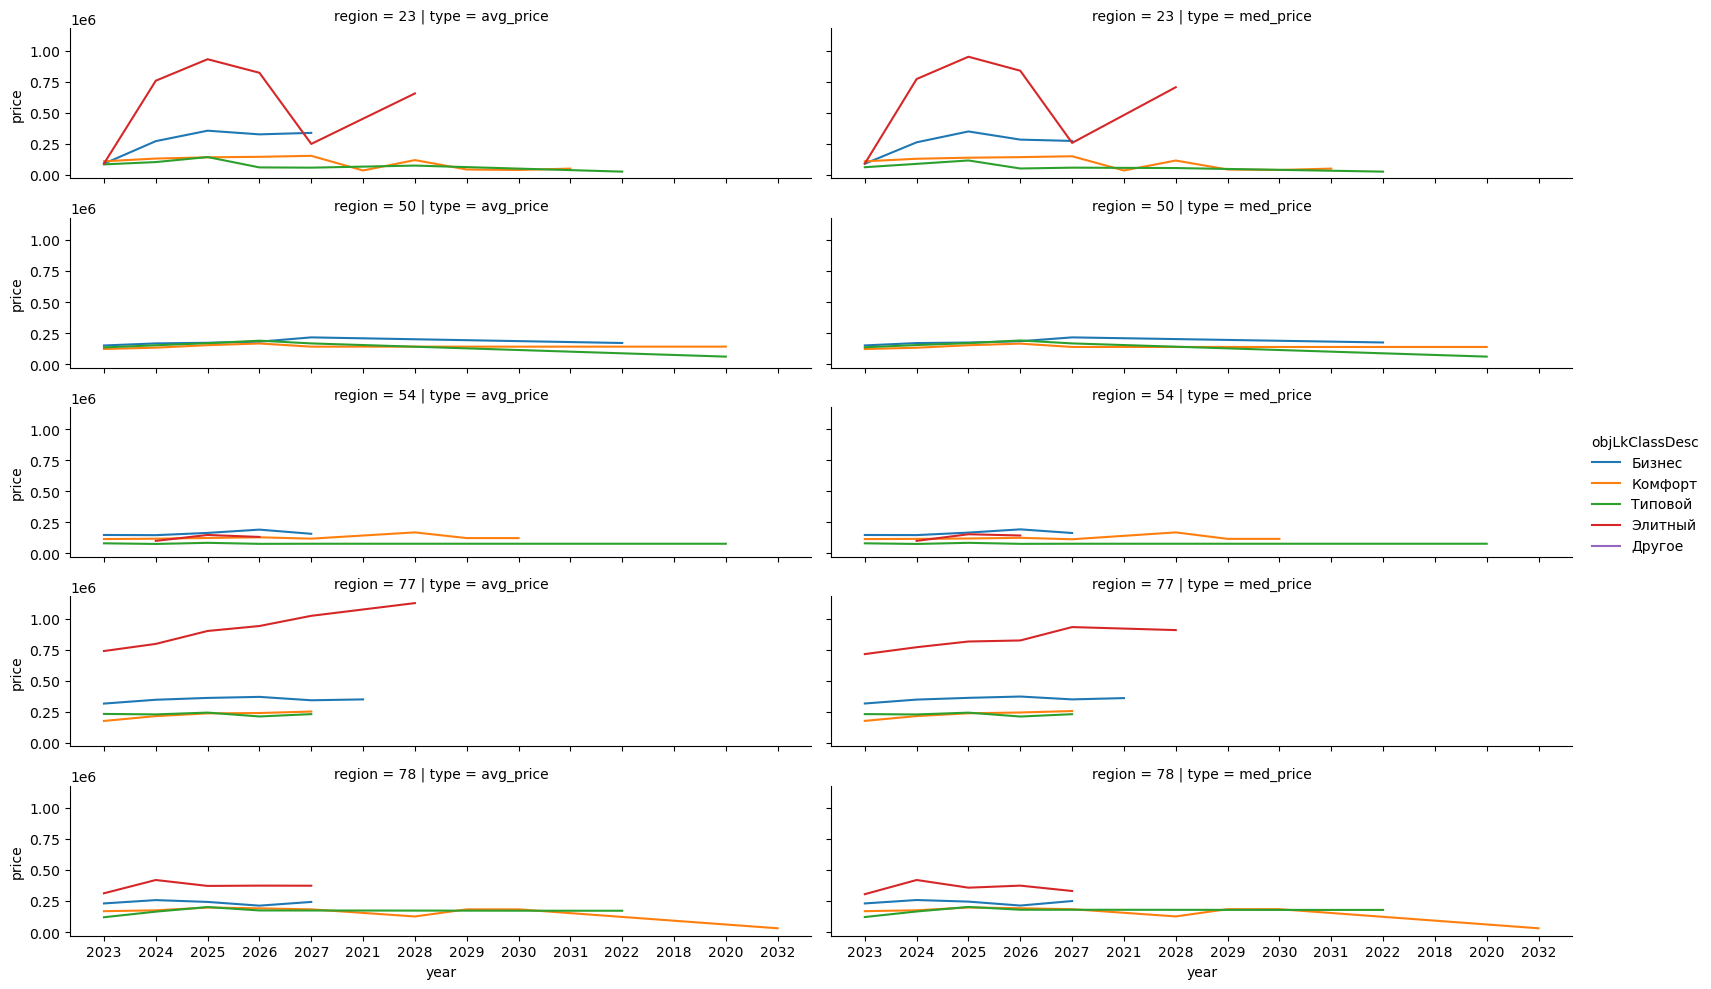

In [21]:
sns.relplot(
    x='year',
    y='price',
    hue='objLkClassDesc',
    data=df_price_long.groupby(['region','objLkClassDesc','year','type'])['price'].mean().reset_index(),
    row='region',
    kind='line',
    col='type',
    aspect=4,
    height=2)



в 23 регионе цены на элитное жилье имеют сильное колебание от года к году, тогда как в других регионах,цены более стабильные. 
в 77 регионе сильнее всего растет элитное жилье

Посмотрим среднее значение цены по регионам за период по нескольим метрикам

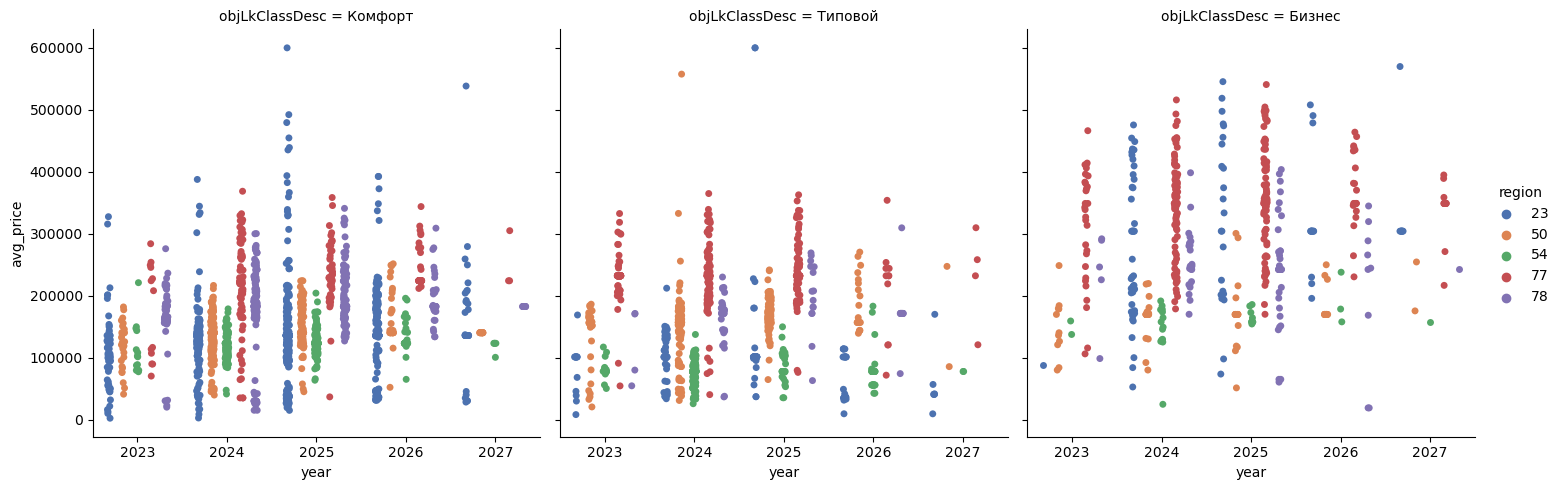

In [22]:
year_check=["2023","2024","2025","2026","2027"]
sns.catplot(
    x='year',
    y='avg_price',
    col='objLkClassDesc',
    order=year_check,
    hue='region',
    data=df.query('objLkClassDesc != "Другое" and objLkClassDesc != "Элитный" and avg_price <=600000'),
    dodge=True,
    palette='deep'
    )

Для более читабельного вида - выведем элитный класс отдельно

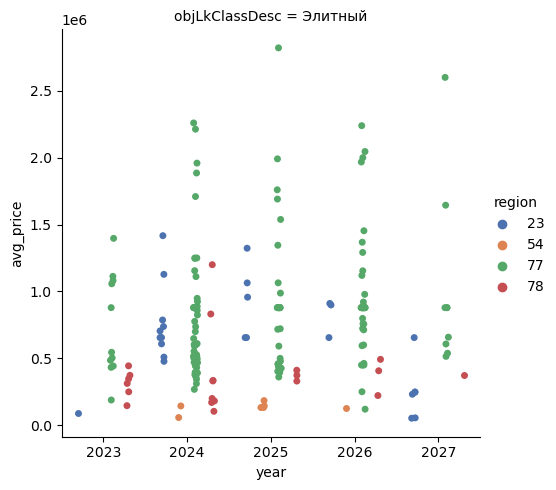

In [23]:
year_check=["2023","2024","2025","2026","2027"]
sns.catplot(
    x='year',
    y='avg_price',
    col='objLkClassDesc',
    order=year_check,
    hue='region',
    data=df.query('objLkClassDesc == "Элитный"'),
    dodge=True,
    palette='deep')

кол-во вводимого жилья

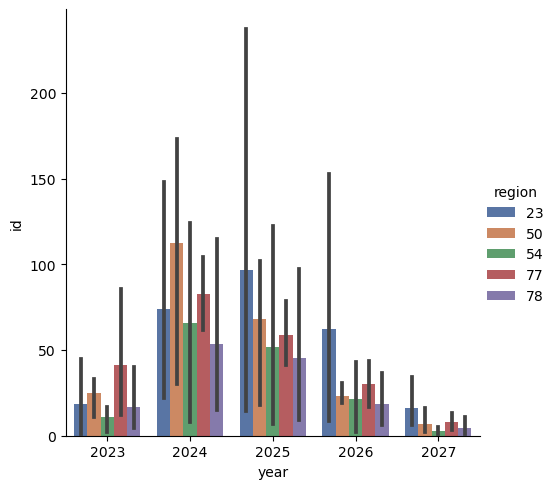

In [24]:
cnt_group=df.groupby(['region','objLkClassDesc','year'])['id'].count().reset_index()
cnt_group.head()

sns.catplot(
    x='year',
    y='id',
    hue='region',
    order=year_check,
    # col='objLkClassDesc',
    data=cnt_group.query('objLkClassDesc != "Другое"'),
    palette='deep',
    kind='bar'
)

разброс по ценам в разрезе года и региона

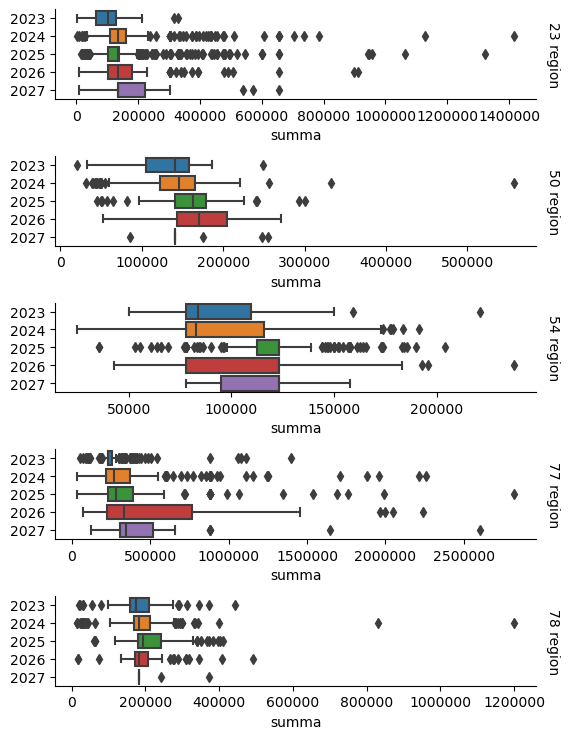

In [25]:
g = sns.catplot(
    data=df,
    x="avg_price", y="year", row="region",
    kind="box", orient="h",order=year_check,
    sharex=False, margin_titles=True,    
    height=1.5, aspect=4,
)
g.set(xlabel="summa", ylabel="")
g.set_titles(row_template="{row_name} region")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter('{x:.0f}')

разброс по классу жилья

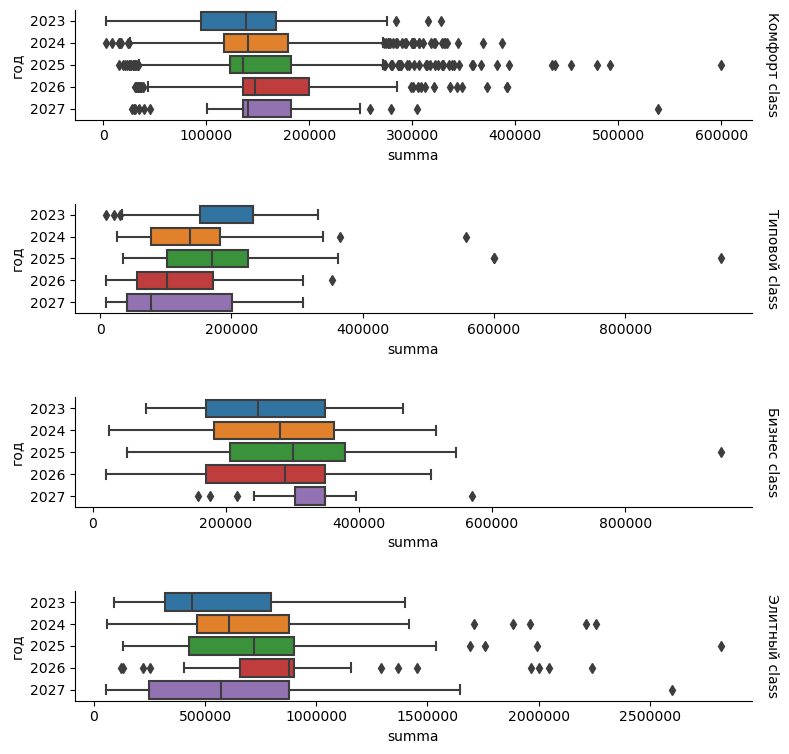

In [27]:
g = sns.catplot(
    data=df.query('objLkClassDesc != "Другое"'),
    x="avg_price",
    y="year",
    row="objLkClassDesc",
    kind="box", 
    orient="h",
    order=year_check,
    sharex=False,
    margin_titles=True,    
    height=2, aspect=4,
)
g.set(xlabel="summa", ylabel="год")
g.set_titles(row_template="{row_name} class")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter('{x:.0f}')

взаимосвязи

In [28]:
df_cor=df[['region','objElemLivingCnt','objElemParkingCnt','objSquareLiving','residentialBuildings'
           ,'objFloorCnt','objFlatCnt','objFlatSq','avg_price','code_type_obj','year','kv_metr']]

C:\Users\mas-e\AppData\Local\Temp\ipykernel_34892\1466054872.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_cor.corr(), annot=True, cmap='rocket')


<Axes: >

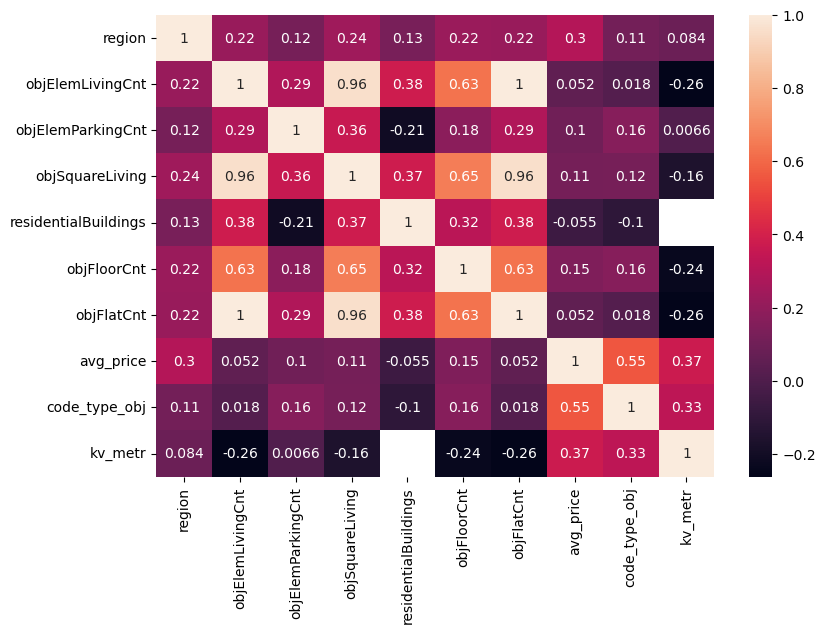

In [29]:
plt.figure(figsize=(9, 6))
sns.heatmap(df_cor.corr(), annot=True, cmap='rocket')


Наиболее сильные взаимосвязи имеют: средняя цена, регион, тип класса объекты,метраж объекта в квадратных метрах